![Logo 1](img/aitech-logotyp-1.jpg)
<div class="alert alert-block alert-info">
<h1> Widzenie komputerowe </h1>
<h2> 06. <i>Rozpoznawanie i segmentacja obrazów</i> [laboratoria]</h2> 
<h3>Andrzej Wójtowicz (2021)</h3>
</div>

![Logo 2](img/aitech-logotyp-2.jpg)

W poniższych materiałach zobaczymy w jaki sposób możemy klasycznym podejściem rozpoznawać ludzi na zdjęciach, a ponadto w jaki sposób szybko podzielić obraz na elementy znajdujące się na pierwszym planie i w tle obrazu.

Na początku załadujmy niezbędne biblioteki.

In [1]:
import cv2 as cv
import numpy as np
import sklearn.svm
import sklearn.metrics
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random

Naszym głównym celem będzie rozpoznawanie ludzi na zdjęciach przy pomocy klasycznej metody *histogram of oriented gradients* (HOG). Krótko mówiąc, dla danego zdjęcia chcemy uzyskać wektor cech, który będziemy mogli wykorzystać w klasyfikatorze SVM. Szczegóły znajdują się w *6.3.2 Pedestrian detection* R. Szeliski (2022) *Computer Vision: Algorithms and Applications*, natomiast tutaj zobrazujemy techniczne wykorzystanie tej metody.

# Klasyfikacja obrazów przy użyciu HOG i SVM

Spróbjemy zbudować klasyfikator, który wskazuje czy na zdjęciu znajduje się osoba z okularami czy bez okularów. Rozpakujmy zbiór danych, z którego będziemy korzystali:

In [4]:
!cd datasets && unzip -qo glasses.zip

Następnie wczytujemy dane i dzielimy je na dwa zbiory w proporcjach 80/20:

In [5]:
dataset_dir = "datasets/glasses"
images_0 = os.listdir(f"{dataset_dir}/with")
images_0 = [f"{dataset_dir}/with/{x}" for x in images_0]
images_1 = os.listdir(f"{dataset_dir}/without")
images_1 = [f"{dataset_dir}/without/{x}" for x in images_1]
images = images_0 + images_1
random.seed(1337)
random.shuffle(images)

train_data = []
test_data = []
train_labels = []
test_labels = []

splitval = int((1-0.2)*len(images))

for x in images[:splitval]:
    train_data.append(cv.imread(x, cv.IMREAD_COLOR))
    train_labels.append(x.split("/")[2])
    
for x in images[splitval:]:
    test_data.append(cv.imread(x, cv.IMREAD_COLOR))
    test_labels.append(x.split("/")[2])
    
d_labels = {"with": 0, "without": 1}
    
train_labels = np.array([d_labels[x] for x in train_labels])
test_labels = np.array([d_labels[x] for x in test_labels])

print(f"Train data: {len(train_data)}, test data: {len(test_data)}")

Train data: 1272, test data: 319


Poniżej znajduje się kilka przykładowych zdjęć.

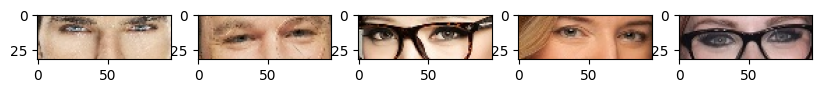

In [6]:
plt.figure(figsize=(10,2))
for i in range(5):
    plt.subplot(151 + i)
    plt.imshow(train_data[i][:,:,::-1]);

Tworzymy deskryptor HOG przy pomocy funkcji [`cv.HOGDescriptor()`](https://docs.opencv.org/4.5.3/d5/d33/structcv_1_1HOGDescriptor.html). Metodą [`compute()`](https://docs.opencv.org/4.5.3/d5/d33/structcv_1_1HOGDescriptor.html#a38cd712cd5a6d9ed0344731fcd121e8b) tworzymy wektory cech, które posłużą nam jako dane wejściowe do klasyfikatora. Poniżej znajduje się również przykładowa konfiguracja deskryptora:

In [7]:
hp_win_size = (96, 32)
hp_block_size = (8, 8)
hp_block_stride = (8, 8)
hp_cell_size = (4, 4)
hp_n_bins = 9
hp_deriv_aperture = 0
hp_win_sigma = 4.0
hp_histogram_norm_type = 1
hp_l2_hys_threshold = 0.2
hp_gamma_correction = True
hp_n_levels = 64
hp_signed_gradient = True

hog_descriptor = cv.HOGDescriptor(
    hp_win_size, hp_block_size, hp_block_stride, hp_cell_size, 
    hp_n_bins, hp_deriv_aperture, hp_win_sigma, 
    hp_histogram_norm_type, hp_l2_hys_threshold, 
    hp_gamma_correction, hp_n_levels, hp_signed_gradient)

train_hog = np.vstack([hog_descriptor.compute(x).ravel() for x in train_data])
test_hog = np.vstack([hog_descriptor.compute(x).ravel() for x in test_data])

Do klasyfikacji użyjemy klasyfikatora SVM. Możemy użyć implementacji znajdującej się w module [`cv.ml`](https://docs.opencv.org/4.5.3/d1/d2d/classcv_1_1ml_1_1SVM.html):

In [8]:
model = cv.ml.SVM_create()
model.setGamma(0.02)
model.setC(2.5)
model.setKernel(cv.ml.SVM_RBF)
model.setType(cv.ml.SVM_C_SVC)

Trenujemy model:

In [9]:
model.train(np.array(train_hog), cv.ml.ROW_SAMPLE, train_labels);

Sprawdzamy wynik na danych testowych:

In [10]:
predictions = model.predict(test_hog)[1].ravel()
accuracy = (test_labels == predictions).mean()
print(f"ACC: {accuracy * 100:.2f} %")

ACC: 92.48 %


Możemy również użyć implementacji klasyfikatora znajdującej się w bibliotece [`scikit-learn`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html):

In [11]:
model = sklearn.svm.SVC(C=2.5, gamma=0.02, kernel='rbf')
model.fit(train_hog, train_labels)

predictions = model.predict(test_hog)
accuracy = (test_labels == predictions).mean()
print(f"ACC: {accuracy * 100:.2f} %")

ACC: 92.48 %


# Rozpoznawanie ludzi

Powyższą metodykę klasyfikcji możemy zastosować do rozpoznawania obiektów na zdjęciach, np. ludzi. W tym wypadku będziemy chcieli wskazać gdzie na zdjęciu znajduje się dany obiekt lub obiekty.

Rozpocznijmy od rozpakowania zbioru danych:

In [12]:
!cd datasets && unzip -qo inria-person-sub.zip

Wczytujemy dane, które są już podzielone na dwa zbiory:

In [13]:
dataset_dir = "datasets/INRIAPerson"

images_train_0 = os.listdir(f"{dataset_dir}/train_64x128_H96/negPatches")
images_train_0 = [f"{dataset_dir}/train_64x128_H96/negPatches/{x}" for x in images_train_0]
images_train_1 = os.listdir(f"{dataset_dir}/train_64x128_H96/posPatches")
images_train_1 = [f"{dataset_dir}/train_64x128_H96/posPatches/{x}" for x in images_train_1]

images_test_0 = os.listdir(f"{dataset_dir}/test_64x128_H96/negPatches")
images_test_0 = [f"{dataset_dir}/test_64x128_H96/negPatches/{x}" for x in images_test_0]
images_test_1 = os.listdir(f"{dataset_dir}/test_64x128_H96/posPatches")
images_test_1 = [f"{dataset_dir}/test_64x128_H96/posPatches/{x}" for x in images_test_1]

train_data = []
test_data = []
train_labels = []
test_labels = []

for x in images_train_0:
    img = cv.imread(x, cv.IMREAD_COLOR)
    if img is not None:
        train_data.append(img)
        train_labels.append(0)

for x in images_train_1:
    img = cv.imread(x, cv.IMREAD_COLOR)
    if img is not None:
        train_data.append(img)
        train_labels.append(1)
    
for x in images_test_0:
    img = cv.imread(x, cv.IMREAD_COLOR)
    if img is not None:
        test_data.append(img)
        test_labels.append(0)

for x in images_test_1:
    img = cv.imread(x, cv.IMREAD_COLOR)
    if img is not None:
        test_data.append(img)
        test_labels.append(1)

print(f"Train data: {len(train_data)}, test data: {len(test_data)}")

Train data: 1457, test data: 560


Poniżej znajduje się kilka przykładowych zdjęć ze zbioru:

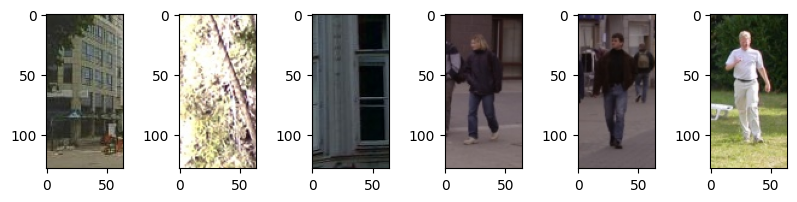

In [14]:
plt.figure(figsize=(10,2))
for i in range(3):
    plt.subplot(161 + i)
    plt.imshow(train_data[i][:,:,::-1]);
for i in range(3):
    plt.subplot(164 + i)
    plt.imshow(train_data[-(i+1)][:,:,::-1]);

Tworzymy deskryptor i wektory cech:

In [15]:
hp_win_size = (64, 128)
hp_block_size = (16, 16)
hp_block_stride = (8, 8)
hp_cell_size = (8, 8)
hp_n_bins = 9
hp_deriv_aperture = 1
hp_win_sigma = -1
hp_histogram_norm_type = 0
hp_l2_hys_threshold = 0.2
hp_gamma_correction = True
hp_n_levels = 64
hp_signed_gradient = False

hog_descriptor = cv.HOGDescriptor(
    hp_win_size, hp_block_size, hp_block_stride, hp_cell_size, 
    hp_n_bins, hp_deriv_aperture, hp_win_sigma, 
    hp_histogram_norm_type, hp_l2_hys_threshold, 
    hp_gamma_correction, hp_n_levels, hp_signed_gradient)

train_hog = np.vstack([hog_descriptor.compute(x).ravel() for x in train_data])
test_hog = np.vstack([hog_descriptor.compute(x).ravel() for x in test_data])

Następnie tworzymy klasyfikator:

In [16]:
model = cv.ml.SVM_create()
model.setGamma(0)
model.setC(0.01)
model.setKernel(cv.ml.SVM_LINEAR)
model.setType(cv.ml.SVM_C_SVC)
model.setTermCriteria((cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 1000, 1e-3))

Uczymy model:

In [17]:
model.train(np.array(train_hog), cv.ml.ROW_SAMPLE, np.array(train_labels));

Sprawdzamy jakość klasyfikacji:

In [18]:
predictions = model.predict(test_hog)[1].ravel()
accuracy = (test_labels == predictions).mean()
print(f"ACC: {accuracy * 100:.2f} %")

ACC: 96.96 %


Poniżej znajduje się podejście przy pomocy biblioteki *scikit-learn*:

In [19]:
model2 = sklearn.svm.SVC(C=0.01, gamma='auto', kernel='linear', max_iter=1000)
model2.fit(train_hog, train_labels)

predictions = model2.predict(test_hog)
accuracy = (test_labels == predictions).mean()
print(f"Accuracy:  {sklearn.metrics.accuracy_score(test_labels, predictions) * 100:.2f} %")
print(f"Precision: {sklearn.metrics.precision_score(test_labels, predictions) * 100:.2f} %")
print(f"Recall:    {sklearn.metrics.recall_score(test_labels, predictions) * 100:.2f} %")

Accuracy:  96.96 %
Precision: 93.55 %
Recall:    88.78 %


Mając teraz wyuczony model, chcielibyśmy sprawdzić czy np. na zdjęciu `img/pedestrians.jpg` znajdują się ludzie, tak aby uzyskać ew. obramowania z ich występowaniem. W pierwszej kolejności w naszym deskryptorze HOG ustawiamy współczynniki klasfikatora SVM przy pomocy metody [`setSVMDetector()`](https://docs.opencv.org/4.5.3/d5/d33/structcv_1_1HOGDescriptor.html#a6de5ac55631eed51e36278cde3a2c159). Następnie przy pomocy metody [`detectMultiScale()`](https://docs.opencv.org/4.5.3/d5/d33/structcv_1_1HOGDescriptor.html#a91e56a2c317392e50fbaa2f5dc78d30b) znajdujemy wyszukiwane obiekty (ludzi) w różnych skalach.

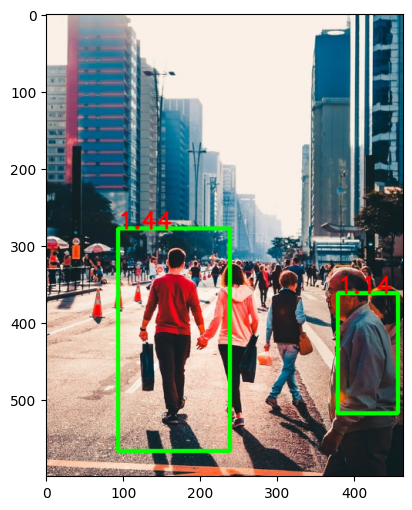

In [20]:
image = cv.imread("img/pedestrians.jpg", cv.IMREAD_COLOR)
scale = 600 / image.shape[0]
image = cv.resize(image, None, fx=scale, fy=scale)

support_vectors = model.getSupportVectors()
rho, _, _ = model.getDecisionFunction(0)
detector = np.zeros(support_vectors.shape[1] + 1, dtype=support_vectors.dtype)
detector[:-1] = -support_vectors[:]
detector[-1] = rho

hog_descriptor.setSVMDetector(detector)

locations, weights = hog_descriptor.detectMultiScale(
    image, winStride=(8, 8), padding=(32, 32), scale=1.05,
    finalThreshold=2, hitThreshold=1.0)

for location, weight in zip(locations, weights):
    x1, y1, w, h = location
    x2, y2 = x1 + w, y1 + h
    cv.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), thickness=3, lineType=cv.LINE_AA)
    cv.putText(image, f"{weight[0]:.2f}", (x1,y1), cv.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv.LINE_AA)

plt.figure(figsize=(6,6))
plt.imshow(image[:,:,::-1]);

Coś nam nawet udało się wykryć jak na tak niewielki zbiór danych uczących ;) Z drugiej strony, dwie osoby na pierwszym planie zostały pominięte, a osoba po prawej jest dyskusyjna jeśli chodzi o zakres oznaczenia.

W OpenCV dostępny jest domyślny klasyfikator w funkcji [`HOGDescriptor_getDefaultPeopleDetector()`](https://docs.opencv.org/4.5.3/d5/d33/structcv_1_1HOGDescriptor.html#a9c7a0b2aa72cf39b4b32b3eddea78203) i poniżej możemy zobaczyć jak sobie radzi na badanym zdjęciu:

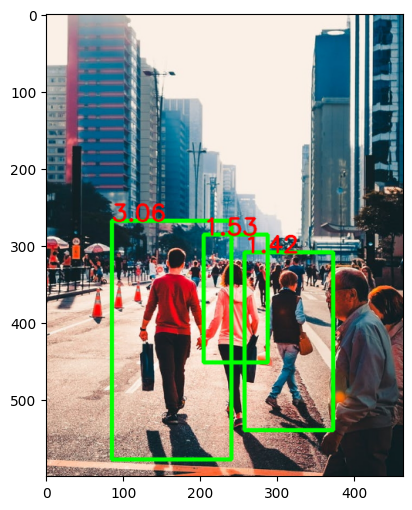

In [21]:
image = cv.imread("img/pedestrians.jpg", cv.IMREAD_COLOR)
scale = 600 / image.shape[0]
image = cv.resize(image, None, fx=scale, fy=scale)

hog_dflt_descriptor = cv.HOGDescriptor(
    hp_win_size, hp_block_size, hp_block_stride, hp_cell_size, 
    hp_n_bins, hp_deriv_aperture, hp_win_sigma, 
    hp_histogram_norm_type, hp_l2_hys_threshold, 
    hp_gamma_correction, hp_n_levels, hp_signed_gradient)

detector_dflt = cv.HOGDescriptor_getDefaultPeopleDetector()
hog_dflt_descriptor.setSVMDetector(detector_dflt)

locations, weights = hog_dflt_descriptor.detectMultiScale(
    image, winStride=(8, 8), padding=(32, 32), scale=1.05,
    finalThreshold=2, hitThreshold=1.0)

for location, weight in zip(locations, weights):
    x1, y1, w, h = location
    x2, y2 = x1 + w, y1 + h
    cv.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), thickness=3, lineType=cv.LINE_AA)
    cv.putText(image, f"{weight[0]:.2f}", (x1,y1), cv.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv.LINE_AA)

plt.figure(figsize=(6,6))
plt.imshow(image[:,:,::-1]);

# Segmentacja obrazu metodą GrabCut

## Zadanie 1

W poniższym zadaniu użyjemy algorytmu [GrabCut](https://en.wikipedia.org/wiki/GrabCut), będącego interaktywną metodą segmentacji obrazu, dzielącą obraz na pierwszy i drugi plan. W OpenCV algorytm jest zaimplementowany w funkcji [`cv.grabCut()`](https://docs.opencv.org/4.5.3/d3/d47/group__imgproc__segmentation.html#ga909c1dda50efcbeaa3ce126be862b37f). Dodatkowe informacje o algorytmie znajdują się w [dokumentacji](https://docs.opencv.org/4.5.3/d8/d83/tutorial_py_grabcut.html).

Przygotuj interaktywną aplikację, która wykorzystuje algorytm GrabCut. W aplikacji powinna być możliwość zaznaczenia początkowego prostokąta, a następnie elementy maski (zwróć uwagę z jakich elementów może składać się maska). Przykładowe działanie możesz zaprezentować na obrazie `img/messi5.jpg`.

![GrabCut - wynik](img/grabcut-result.png)

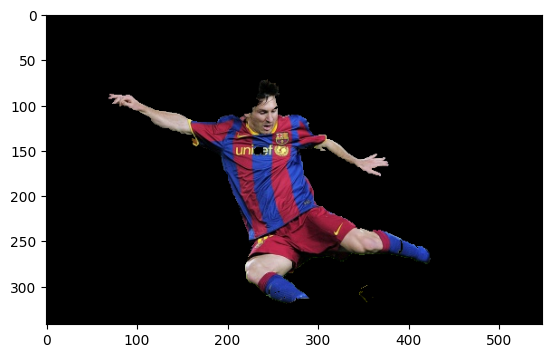

In [3]:
img = cv.imread("img/messi5.jpg")

top_left_corner=[]
bottom_right_corner=[]
rectangle_selected = True
mode = True
drawing = False
rect = (0,0,0,0)
mask = np.zeros(img.shape[:2],np.uint8)
mask += 2
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

def drawRectangle(action, x, y, flags, *userdata):
  global top_left_corner, bottom_right_corner, rectangle_selected, mode, drawing, rect

  if rectangle_selected is True:
    if action == cv.EVENT_LBUTTONDOWN:
      top_left_corner = [(x,y)]
    elif action == cv.EVENT_LBUTTONUP:
      bottom_right_corner = [(x,y)]    
      cv.rectangle(img, top_left_corner[0], bottom_right_corner[0], (255,0,0),2, 8)
      for x in range(len(mask)):
        for y in range(len(mask[0])):
          if x < top_left_corner[0][1] or x > bottom_right_corner[0][1] or y < top_left_corner[0][0] or y > bottom_right_corner[0][0]:
            mask[x][y] = 0
      plt.imshow(mask)
      rectangle_selected = False
  else:
    if action == cv.EVENT_LBUTTONDOWN:
        drawing = True
    elif action == cv.EVENT_MOUSEMOVE:
        if drawing == True:
            if mode == True:
                cv.circle(img,(x,y),3,(0,255,0),-1)
            else:
                cv.circle(img,(x,y),3,(0,0,255),-1)
    elif action == cv.EVENT_LBUTTONUP:
        drawing = False


window_name = 'Messi';
cv.namedWindow(window_name)
cv.setMouseCallback(window_name, drawRectangle)

img = cv.imread("img/messi5.jpg")
while True:
  cv.imshow(window_name, img)
  code = cv.waitKey(1)

  if code == ord('q'):
    break
  if code == ord('m'):
    mode = not mode
  if code == ord('g'):
    for x in range(len(img)):
      for y in range(len(img[0])):
        if (img[x][y] == (0, 0, 255)).all():
          mask[x][y] = 0
        if (img[x][y] == (0, 255, 0)).all():
          mask[x][y] = 1

    img = cv.imread("img/messi5.jpg")
    cv.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv.GC_INIT_WITH_MASK)
    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    img = img*mask2[:,:,np.newaxis]
    plt.imshow(img[:,:,::-1])
    break
    
cv.destroyAllWindows()